In [180]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt

# Load Data

In [3]:
weekly_activity_df = pd.read_pickle('weekly_activity_format.pkl')

X = np.array(list(weekly_activity_df['X']))
y = np.array(weekly_activity_df['y'])

## Split Data Into training and testing

In [5]:
from torch import nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# check if gpu is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 3)

In [212]:
# make datasets into torch tensors
X_train, y_train = torch.from_numpy(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.from_numpy(X_test).float(), torch.tensor(y_test).float()
X_val, y_val = torch.from_numpy(X_val).float(), torch.tensor(y_val).float()

In [213]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

## Create Dataloader

In [214]:
from torch.utils.data import DataLoader, Dataset

In [215]:
class oversampdata(Dataset):
    def __init__(self, x_data, targets):
        self.data = x_data
        self.targets = targets

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        target = self.targets[index]
        data_val = self.data[index]
        
        return data_val, target

In [216]:
train_dataset = oversampdata(X_train, y_train)
valid_dataset = oversampdata(X_test, y_test)

In [217]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Utility Functions

In [218]:
def binary_acc(y_pred, y_test):
    y_pred = y_pred.cpu()
    y_test = y_test.cpu()
    y_pred_tag = torch.round(y_pred.squeeze(1))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    #acc = torch.round(acc * 100)
    
    return acc

# Recurrent Neural Networks

In [219]:
class RNN_LSTM(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size, n_layers=1): 
        super(RNN_LSTM, self).__init__()
        
        self.rnn_layer = nn.LSTM(input_size, hidden_size, n_layers, bidirectional = True)
        self.fc1 = nn.Linear(hidden_size*2*20, 16)
        self.fc2 = nn.Linear(16, output_size)
        
    def forward(self, inp): 
        output, hidden = self.rnn_layer(inp)
        
        x = self.fc1(output.view( output.size(0), -1) )
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x
    
    
class RNN_GRU(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size, n_layers=1): 
        super(RNN_GRU, self).__init__()
        
        self.rnn_layer = nn.GRU(input_size, hidden_size, n_layers, bidirectional = True)
        self.fc1 = nn.Linear(hidden_size*2*20, 16)
        self.fc2 = nn.Linear(16, output_size)
        
    def forward(self, inp): 
        output, hidden = self.rnn_layer(inp)
        
        x = self.fc1(output.view( output.size(0), -1) )
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x

In [220]:
def train_model(rnn_net, rnn_net_best_val, train_loader=train_loader, X_val=X_val, verbose = True): 
    # set loss function, optimizer and criterion
    criterion = nn.BCELoss()
    optimizer = optim.Adam(rnn_net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    # set training to gpu if exists
    rnn_net.to(device)
    rnn_net_best_val.to(device)

    # training parameters
    n_steps = 15
    best_val_loss = 100

    # train model
    for i in range(n_steps):
        for i, data in enumerate(train_loader, 0):        
            inputs, labels = data        
            optimizer.zero_grad()
            y_pred_train = rnn_net(inputs)
            loss_train = criterion(y_pred_train,labels.unsqueeze(1))        
            loss_train.backward()        
            optimizer.step()

        # validation loss
        y_pred_val = rnn_net(X_val)
        loss_val = criterion(y_pred_val, y_val.unsqueeze(1))
        if (best_val_loss > loss_val.cpu().detach().numpy()): 
            rnn_net_best_val.load_state_dict(rnn_net.state_dict())
            best_val_loss = loss_val.cpu().detach().numpy()
            if (verbose): 
                print("Updated best val model")

        # print loss
        if(verbose): 
            print(loss_val.cpu().detach().numpy())
            
    return rnn_net, rnn_net_best_val

In [221]:
week_scope = 42

# define training data
train_dataset = oversampdata(X_train[:, :, :week_scope], y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

X_val_week = X_val[:, :, :week_scope]

In [222]:
# define model instance
rnn_net = RNN_GRU(X_train[:, :, :week_scope][0].shape[1], 10, 1, n_layers = 1)
rnn_net_best_val = RNN_GRU(X_train[:, :, :week_scope][0].shape[1], 10, 1, n_layers = 1)

In [223]:
# train model 
rnn_net, rnn_net_best_val = train_model(rnn_net, rnn_net_best_val, train_loader, X_val_week, verbose = True)

Updated best val model
0.26447475
Updated best val model
0.24170049
Updated best val model
0.2300368
0.23206632
0.23347226
Updated best val model
0.22003374
0.2282457
0.22934256
0.22998051
0.22834414
0.24403058
0.22859058
0.22825998
0.22732142
0.23508997


In [224]:
y_eval = rnn_net_best_val(X_test[:, :, :week_scope])
binary_acc(y_eval, y_test)

tensor(0.9148)

In [225]:
y_pred_binary = torch.round(y_eval.cpu().squeeze(1))

In [226]:
print(classification_report(y_test.cpu().detach().numpy(), y_pred_binary.detach().numpy()))

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91      2757
         1.0       0.88      0.97      0.92      3042

    accuracy                           0.91      5799
   macro avg       0.92      0.91      0.91      5799
weighted avg       0.92      0.91      0.91      5799



## 4-Week period data predictions 

In [156]:
week_scopes = list(range(12, 42, 4))
gru_accs = []
lstm_accs = []

### GRU

In [164]:
for week_scope in week_scopes: 
    print("Scope: ", week_scope)
    # define training data
    train_dataset = oversampdata(X_train[:, :, :week_scope], y_train)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    X_val_week = X_val[:, :, :week_scope]

    # define model instance
    rnn_net = RNN_GRU(X_train[:, :, :week_scope][0].shape[1], 10, 1, n_layers = 1)
    rnn_net_best_val = RNN_GRU(X_train[:, :, :week_scope][0].shape[1], 10, 1, n_layers = 1)

    # train model 
    rnn_net, rnn_net_best_val = train_model(rnn_net, rnn_net_best_val, train_loader, X_val_week, verbose = False)

    y_eval = rnn_net_best_val(X_test[:, :, :week_scope])
    gru_accs.append(binary_acc(y_eval, y_test).item())
    print("Accuract: ", binary_acc(y_eval, y_test).item())
    print()

Scope:  12
Accuract:  0.715468168258667

Scope:  16
Accuract:  0.7482324242591858

Scope:  20
Accuract:  0.7951371073722839

Scope:  24
Accuract:  0.8289360404014587

Scope:  28
Accuract:  0.8653216361999512

Scope:  32
Accuract:  0.881531298160553

Scope:  36
Accuract:  0.9051560759544373

Scope:  40
Accuract:  0.9141231179237366



### LSTM

In [165]:
for week_scope in week_scopes: 
    print("Scope: ", week_scope)
    # define training data
    train_dataset = oversampdata(X_train[:, :, :week_scope], y_train)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    X_val_week = X_val[:, :, :week_scope]

    # define model instance
    rnn_net = RNN_LSTM(X_train[:, :, :week_scope][0].shape[1], 10, 1, n_layers = 1)
    rnn_net_best_val = RNN_LSTM(X_train[:, :, :week_scope][0].shape[1], 10, 1, n_layers = 1)

    # train model 
    rnn_net, rnn_net_best_val = train_model(rnn_net, rnn_net_best_val, train_loader, X_val_week, verbose = False)

    y_eval = rnn_net_best_val(X_test[:, :, :week_scope])
    lstm_accs.append(binary_acc(y_eval, y_test).item())
    print("Accuract: ", binary_acc(y_eval, y_test).item())
    print()

Scope:  12
Accuract:  0.7280565500259399

Scope:  16
Accuract:  0.7490946650505066

Scope:  20
Accuract:  0.7972064018249512

Scope:  24
Accuract:  0.8311777710914612

Scope:  28
Accuract:  0.86411452293396

Scope:  32
Accuract:  0.8820486068725586

Scope:  36
Accuract:  0.903948962688446

Scope:  40
Accuract:  0.9123986959457397



## Plot model results for the weekly periods

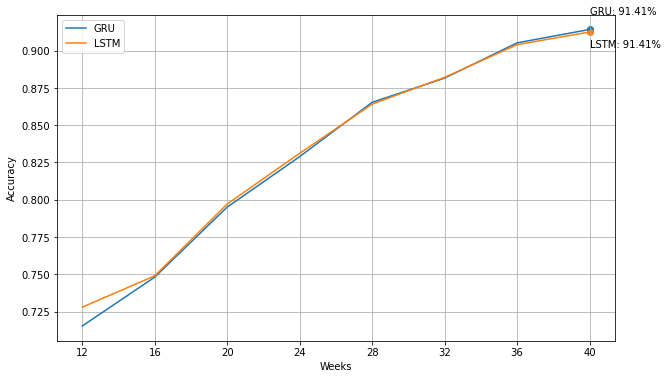

In [194]:
plt.figure(figsize=(10, 6))
# plot period lines
plt.plot(week_scopes, gru_accs, label='GRU')
plt.plot(week_scopes,lstm_accs, label='LSTM')
# plot accuracy points
plt.scatter([week_scopes[-1]], [gru_accs[-1]])
plt.annotate("GRU: "+str(round(gru_accs[-1]*100, 2))+"%", (week_scopes[-1], gru_accs[-1]+0.01))
plt.scatter([week_scopes[-1]], [lstm_accs[-1]])
plt.annotate("LSTM: "+str(round(gru_accs[-1]*100, 2))+"%", (week_scopes[-1], lstm_accs[-1]-0.01))
# make labels
plt.legend()
plt.xlabel('Weeks')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(week_scopes)
plt.show()

## Test last half of data

In [228]:
week_scope = 21

# define training data
train_dataset = oversampdata(X_train[:, :, week_scope:], y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

X_val_week = X_val[:, :, week_scope:]

# define model instance
rnn_net = RNN_GRU(X_train[:, :, week_scope:][0].shape[1], 10, 1, n_layers = 1)
rnn_net_best_val = RNN_GRU(X_train[:, :, week_scope:][0].shape[1], 10, 1, n_layers = 1)

# train model 
rnn_net, rnn_net_best_val = train_model(rnn_net, rnn_net_best_val, train_loader, X_val_week, verbose = False)

y_eval = rnn_net_best_val(X_test[:, :, week_scope:])
print(binary_acc(y_eval, y_test).item())

0.915502667427063
